# Crop ID

This notebook uses data from NASA's Aqua and Terra satellites to identify crops across Iowa.

In [1]:
import os, logging, requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
import shapely, json, itertools, geojson, requests
from ibmpairs import paw, authentication
from datetime import datetime, timedelta
from urllib.parse import urljoin
from pathlib import Path

We set some global variables and configure the logging system.

In [2]:
oneSec = timedelta(seconds=1)
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

logging.basicConfig(level=logging.WARNING)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.ERROR)

## PAIRS credentials

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [3]:
pairs_api_key = '<YOUR-PAIRS-API-KEY>'

In [4]:
pairs_credentials = authentication.OAuth2(api_key=pairs_api_key)

In [5]:
pairs_auth_headers={
    'authorization' : f'Bearer {pairs_credentials.jwt_token}',
    'content-type' : 'application/json'
}

The token will expire after an hour. This notebook will run in less time, so this is no issue. For longer running jobs use `pairs_credentials.refresh_auth_token()` to refresh. See https://pairs.res.ibm.com/tutorial/tutorials/api/paw.html#refreshing-a-token for details.

To start, let us take a look crops growing across Iowa. So we need to find the AOI identifier for the state. We simply search the database:

In [6]:
aoi_list = requests.get(
    'https://pairs.res.ibm.com/ws/queryaois/repository/search?name=Iowa', headers=pairs_auth_headers
).json()
[
    aoi for aoi in aoi_list if aoi.get('hierarchy') == 'state'
]

[{'id': 136, 'key': 'usa-iowa', 'name': 'USA - Iowa', 'hierarchy': 'state'}]

The _cropscape_ layer contains information about crops across the United States at 30 meters resolution. The layer's PAIRS ID is 111. Note that the timestamp corresponds to the beginning of the year (January 1st) during which the crop was grown. At full resolution, PAIRS would return a GeoTiff of about 25,000x12,500 pixels. Since we only want to get an overview, we instruct PAIRS to coarsen the resolution by a factor of 4 using the `coarse_grain` postprocessor.

In [7]:
queryJson = {
    'layers' : [{'id' : '111'}],
    'spatial' : {'type' : 'poly', 'aoi' : '136'},
    'temporal' : {'intervals' : [{'snapshot' : datetime(2010, 1, 1).strftime(iso8601)}]},
    'processor' : [{
        'order' : 1,
        'type' : 'coarse-grain',
        'options' : [
            {'name' : 'levelsUp', 'value' : '4'},
            {'name' : 'aggregation', 'value' : 'mode'}
        ]
    }]
}

We submit the query. Note the use over `overwriteExisting`. This lets the `paw` library re-use locally cached data.

In [8]:
query = paw.PAIRSQuery(queryJson, auth=pairs_credentials, authType='api-key', overwriteExisting=False)
query.submit()

In [9]:
query.poll_till_finished()
query.download()
query.create_layers()

To start, let's identify the most common crops across Iowa. Note that the pixel count here is for the coarse-grained data. I.e. it is a factor of 16 lower than the actual data. Not surprisingly, we find a lot of Corn and Soy during 2010. Note also that the remaining area is roughly the same as that covered by each of those crops.

In [10]:
attributes = {
    1 : 'Corn', 5 : 'Soybeans', 36 : 'Alfalfa', 37 : 'Other Hay/Non Alfalfa',
    111 : 'Open Water', 121 : 'Developed/Open Space', 122 : 'Developed/Low Intensity',
    141 : 'Deciduous Forest', 176 : 'Grassland/Pasture', 190 : 'Woody Wetlands'
}
mostCommonAttributes = pd.Series(
    query.data['Historical crop planting map (USA)-Crop_30_m-01_01_2010T00_00_00'].reshape(-1), name='Pixels'
).dropna().value_counts()
pd.merge(pd.Series(attributes, name='Name'), mostCommonAttributes, left_index=True, right_index=True).sort_values(['Pixels'], ascending=False)

,Name,Pixels
1.0,Corn,359970
5.0,Soybeans,263178
176.0,Grassland/Pasture,183586
141.0,Deciduous Forest,79609
121.0,Developed/Open Space,47664
122.0,Developed/Low Intensity,14535
111.0,Open Water,12688
190.0,Woody Wetlands,10813
36.0,Alfalfa,7223
37.0,Other Hay/Non Alfalfa,3910


In [11]:
mostCommonAttributes[~mostCommonAttributes.index.isin([1., 5.])].sum()

371160

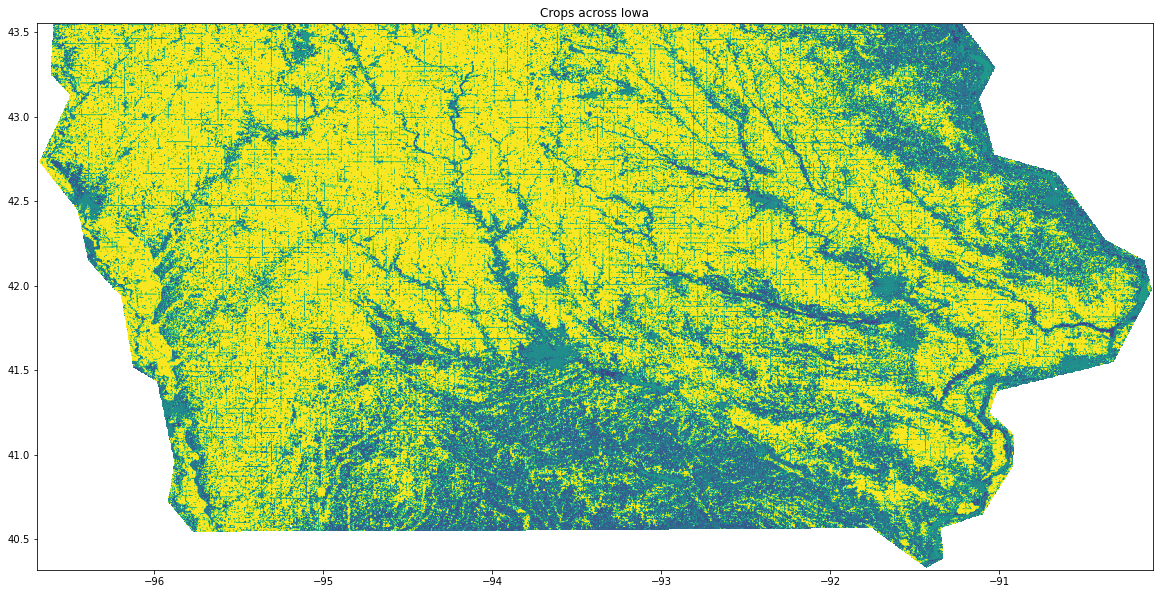

In [12]:
bBox = query.metadata['Historical crop planting map (USA)-Crop_30_m-01_01_2010T00_00_00']['details']['boundingBox']
plt.figure(figsize=(20, 14))
plt.imshow(
    query.data['Historical crop planting map (USA)-Crop_30_m-01_01_2010T00_00_00'], cmap='viridis_r',
    extent=(bBox['minLongitude'], bBox['maxLongitude'], bBox['minLatitude'], bBox['maxLatitude'])
)
plt.title('Crops across Iowa')
plt.show()

## Model building

Roughly speaking _Normalized Difference Vegetation Index_ (NDVI) measures the amount of vegetation capable of photosynthesis across the pixel. Thus, it is an efficient tool to monitor plant life from satellite or aerial images. We will now use NDVI measurements from NASA's Aqua and Terra satellites to identify crops across the state.

The specific data layers we are using have PAIRS IDs 51 and 71. They are products released every 16 days by NASA that are free of clouds and thus easy to work with. To keep things simple, we will request data for an entire year. Depending on the use case, an operational model might run during the growing season, when less data is available.

NDVI is not the only indicator of crops. Indeed, pixels covered by forests or urban developments are unlikely to turn into cropland. Moreover, past growing decisions made by a farmer might influence the future. We thus also use last year's crop as input to our model. This is all encaptulated in the following query:

In [13]:
def getQueryJson(year, coordinates):
    queryJson = {
        'layers' : [
            {'id' : '51'},
            {'id' : '71'},
            {
                'id' : '111',
                'temporal' : {'intervals' : [{
                    'start' : datetime(year-2, 1, 1).strftime(iso8601),
                    'end' : datetime(year, 1, 1).strftime(iso8601)
                }]}
            }
        ],
        'spatial' : {'type' : 'point', 'coordinates' : coordinates},
        'temporal' : {'intervals' : [{
            'start' : datetime(year, 1, 1).strftime(iso8601),
            'end' : (datetime(year+1, 1, 1)-oneSec).strftime(iso8601)
        }]},
    }
    return queryJson

In [14]:
query = paw.PAIRSQuery(getQueryJson(2016, [49., -94.]), auth=pairs_credentials, authType='api-key')
query.submit()

In [15]:
query.vdf.head()

,layerId,timestamp,longitude,latitude,value,region,property,geometry
0,51,2016-01-09 00:00:00+00:00,-94.0,49.0,0.5711,NaN,NaN,POINT (-94 49)
1,51,2016-01-25 00:00:00+00:00,-94.0,49.0,0.3455,NaN,NaN,POINT (-94 49)
2,51,2016-02-10 00:00:00+00:00,-94.0,49.0,0.1269,NaN,NaN,POINT (-94 49)
3,51,2016-02-26 00:00:00+00:00,-94.0,49.0,0.1972,NaN,NaN,POINT (-94 49)
4,51,2016-03-13 00:00:00+00:00,-94.0,49.0,0.5597,NaN,NaN,POINT (-94 49)


There are many different ways to train such model. We could request the entire raster across the state, possibly pre-processed in PAIRS to give monthly means. Instead, we will stream point queries to the machine training our classifier while training -- without storing any information locally. The rapid speed of PAIRS point queries makes this possible.

We will randomly sample points across Iowa via rejection sampling. To do so, we need a polygon covering the state, which we load from PAIRS.

In [16]:
iowa = requests.get(
    'https://pairs.res.ibm.com/ws/queryaois/geojson/136', headers=pairs_auth_headers
)
iowa = iowa.text.rstrip()[1:-1].replace('""', '"')
iowa = shapely.geometry.shape(geojson.loads(iowa))[0]

lonsIowa, latsIowa = iowa.boundary.xy
bBoxIowa = np.min(latsIowa), np.min(lonsIowa), np.max(latsIowa), np.max(lonsIowa)

### Training a neural network

We build a very simple neural network using pytorch.

In [17]:
import torch, torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

For reproducibility, we fix the random seeds.

In [18]:
torch.manual_seed(0)
np.random.seed(0)

The following dataset allows us to stream data from PAIRS into the neural networks training process.

In [19]:
class Dataset(IterableDataset):
    def __init__(self, years, aoi, batchSize):
        self.years = years
        self.aoi = aoi
        self.rng = None
        self.batchSize = batchSize
        
        lons, lats = aoi.boundary.xy
        self.bBox = np.min(lats), np.min(lons), np.max(lats), np.max(lons)
    
    def __iter__(self):
        while True:
            # Pick a random year
            year = self.rng.choice(self.years)
            # Sample batchSize samples from across the state (via rejection sampling)
            samples = list()
            while len(samples) < self.batchSize:
                lat, lon = self.rng.uniform(self.bBox[0], self.bBox[2]), self.rng.uniform(self.bBox[1], self.bBox[3])
                if shapely.geometry.Point(lon, lat).within(self.aoi):
                    samples.append((lat, lon))
            samples = list(itertools.chain(*samples))
            
            # Query PAIRS
            queryJson = getQueryJson(year, samples)
            query = paw.PAIRSQuery(queryJson, auth=pairs_credentials, authType='api-key')
            query.submit()
            
            # Data postprocessing
            query.vdf['value'] = pd.to_numeric(query.vdf['value'])
            # For the NDVI data, we compute a series of monthly aggregates
            ndviData = query.vdf.loc[
                query.vdf['layerId'].isin([51, 71]),
                ['timestamp', 'latitude', 'longitude', 'value']
            ]
            ndviData['month'] = ndviData['timestamp'].dt.month
            X = ndviData.groupby(['latitude', 'longitude', 'month']).aggregate({'value' : ['median', 'mean', 'min', 'max']}).unstack('month')
            X.columns = X.columns.droplevel(0)

            # For the crops, we replace the labels.
            # 1 will be corn, 2 soybean and 0 neither
            cropData = query.vdf.loc[query.vdf['layerId'] == 111].copy()
            cropData.loc[~cropData['value'].isin([1, 5]), 'value'] = 0
            cropData.loc[cropData['value']==5, 'value'] = 2
            # We also split into training target and last year's crop
            y = cropData[cropData['timestamp'].dt.year == year].set_index(['latitude', 'longitude'])['value']
            xCrop = cropData[cropData['timestamp'].dt.year == year-1].set_index(['latitude', 'longitude'])['value']
            
            # We assemble the final data frame.
            X[('Last Crop', 'Neither')] = xCrop==0
            X[('Last Crop', 'Corn')] = xCrop==1
            X[('Last Crop', 'Soybeans')] = xCrop==2
            # To consistently remove missing values, we briefly join all data frames
            X[('y', '')] = y
            X = X.dropna(how='any')
            y = X[('y', '')]
            X = X.drop([('y', '')], 1)
            
            yield y.astype(np.int64), X.astype(np.float32)
            
# We use the worker init function to handle each process its own random number generator
def workerInitFn(workerId):
    worker = get_worker_info()
    worker.dataset.rng = np.random.default_rng(seed=worker.seed)

Our neural network is very simple. Three fully connected layers, ReLU activations. We optimize a cross entropy loss.

In [20]:
net = nn.Sequential(
    nn.Linear(51, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 3)
)
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters())

For training, we use data from 2001 to 2016. Subsequently we will evaluate the network on data from 2018 and 2019.

In [21]:
yearsTrain = list(range(2001, 2017))
yearsTest = list(range(2018, 2020))
dataTrain = Dataset(yearsTrain, iowa, 64)
dataTest = Dataset(yearsTest, iowa, 64)
dataLoaderTrain = DataLoader(dataTrain, batch_size=None, batch_sampler=None, num_workers=4, worker_init_fn=workerInitFn)
dataLoaderTest = DataLoader(dataTest, batch_size=None, batch_sampler=None, num_workers=4, worker_init_fn=workerInitFn)

In [22]:
y, X = next(iter(dataLoaderTrain))

In [23]:
y.head()

latitude   longitude 
40.661995  -91.131030    0
40.667383  -94.826384    2
40.673324  -94.651854    0
40.734878  -95.847386    1
40.835610  -95.821217    1
Name: (y, ), dtype: int64

In [24]:
X.head()

median                                               \
month                      1        2        3        4        5        6   
latitude  longitude                                                         
40.661995 -91.131030 -0.0236 -0.01980 -0.16960 -0.03935 -0.12795 -0.11595   
40.667383 -94.826384  0.2498  0.24155  0.27520  0.37455  0.53990  0.66140   
40.673324 -94.651854  0.2425  0.25520  0.33115  0.49065  0.67860  0.74025   
40.734878 -95.847386  0.2163 -0.03380  0.23605  0.30735  0.37340  0.69945   
40.835610 -95.821217  0.1983 -0.03640  0.20125  0.19175  0.24900  0.66180   

                                                         ...     max          \
month                       7        8       9       10  ...       6       7   
latitude  longitude                                      ...                   
40.661995 -91.131030 -0.03390 -0.08335 -0.0593 -0.17160  ...  0.0039  0.0127   
40.667383 -94.826384  0.86965  0.86010  0.5027  0.32920  ...  0.8028  0.8981   
40.673324 -94.651854  0.79660  0.79425  0.5720  0.44080  ...  0.8056  0.8081   
40.734878 -95.847386  0.81265  0.77805  0.4959  0.29880  ...  0.7968  0.8248   
40.835610 -95.821217  0.84530  0.82170  0.4589  0.28195  ...  0.8311  0.8689   

                                                             Last Crop       \
month                      8       9      10      11      12   Neither Corn   
latitude  longitude                                                           
40.661995 -91.131030 -0.0334  0.1864 -0.1389  0.0323 -0.0463       1.0  0.0   
40.667383 -94.826384  0.8958  0.7936  0.3867  0.3016  0.2715       0.0  1.0   
40.673324 -94.651854  0.8013  0.7187  0.4987  0.3723  0.2876       0.0  0.0   
40.734878 -95.847386  0.8192  0.7085  0.3486  0.2871  0.2639       0.0  1.0   
40.835610 -95.821217  0.8597  0.6282  0.3228  0.2568  0.2225       0.0  0.0   

                               
month                Soybeans  
latitude  longitude            
40.661995 -91.131030      0.0  
40.667383 -94.826384      0.0  
40.673324 -94.651854      1.0  
40.734878 -95.847386      0.0  
40.835610 -95.821217      1.0  

[5 rows x 51 columns]

#### Training

In [25]:
losses = list()
batchGenerator = iter(dataLoaderTrain)
for _ in tqdm(range(256)):
    y, X = next(batchGenerator)
    yTensor = torch.from_numpy(y.values).cuda()
    XTensor = torch.from_numpy(X.values).cuda()
    optimizer.zero_grad()
    yHat = net(XTensor)
    loss = criterion(yHat, yTensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████| 256/256 [01:55<00:00,  2.21it/s]


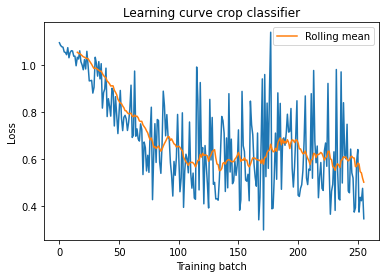

In [26]:
plt.plot(losses)
plt.plot(pd.Series(losses).rolling(16).mean(), label='Rolling mean')
plt.legend()
plt.xlabel('Training batch')
plt.ylabel('Loss')
plt.title('Learning curve crop classifier')
plt.savefig('learningCurve.png', dpi=60, bbox_inches='tight')
plt.show()

#### Evaluation

In [27]:
total, correctNN, correctPersistence = 0, 0, 0
batchGenerator = iter(dataLoaderTest)
for _ in tqdm(range(256)):
    y, X = next(batchGenerator)
    yTensor = torch.from_numpy(y.values).cuda()
    XTensor = torch.from_numpy(X.values).cuda()
    with torch.no_grad():
        yHat = net(XTensor)
        loss = criterion(yHat, yTensor)
        _, prediction = torch.max(yHat, 1)
        total += prediction.size(0)
        correctNN += (prediction == yTensor).sum().item()
        persistence = np.argmax(X['Last Crop'].values, 1)
        correctPersistence += (persistence == y).sum()

100%|████████████████████████████████████████████████████████████████████████| 256/256 [01:59<00:00,  2.15it/s]


In [28]:
correctNN / total, correctPersistence / total

(0.8485274349260662, 0.4600391054625443)

Thus, we have achieved an accuracy of about 85%.